In [ ]:
# ============================================================
# 1. SETUP
# ============================================================
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from google.colab import drive
drive.mount('/content/drive')

# ROOT directory containing images + Excel
DATA_ROOT = "/content/drive/MyDrive/malaria"
IMG_DIR = os.path.join(DATA_ROOT, "images")
LABEL_FILE = os.path.join(DATA_ROOT, "LifeStages.xlsx")

print("Files:", os.listdir(DATA_ROOT))

Mounted at /content/drive
Files: ['LifeStages.xlsx', 'masks', 'augmented', 'images']


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Columns now: Index(['Image', 'LifeStage', 'center_x', 'center_y'], dtype='object')
                                         Image LifeStage  center_x  center_y
0  Trip 017 Day 1 19-10-05 Image 14 add_10.png      Esch       457       603
1  Trip 017 Day 1 19-10-05 Image 16 add_15.png      Esch      1241       276
2   Trip 017 Day 1 19-10-05 Image 14 add_1.png      Esch       726       763
3  Trip 017 Day 1 19-10-05 Image 15 add_16.png      Esch       281       809
4  Trip 017 Day 1 19-10-05 Image 15 add_16.png      Esch       821       794


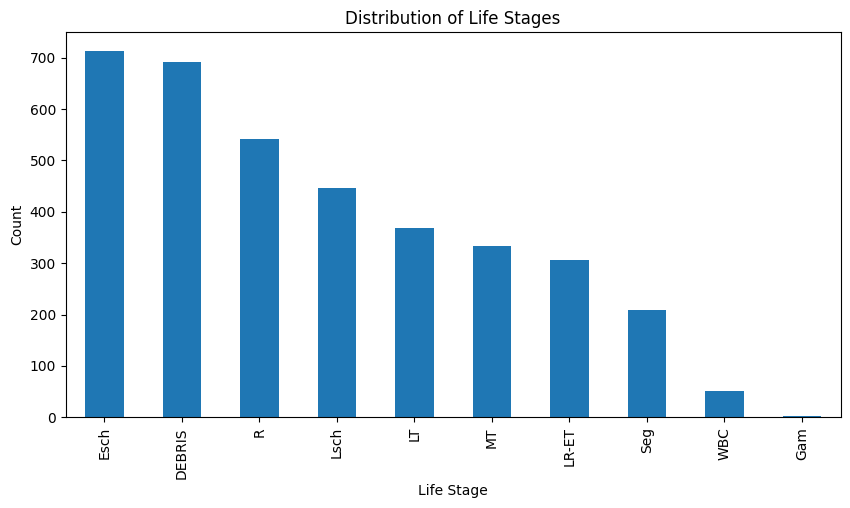

In [ ]:
# ============================================================
# 2. LOAD LABELS + VISUALIZE CLASS DISTRIBUTION
# ============================================================

df = pd.read_excel(LABEL_FILE)

df.columns = [c.strip() for c in df.columns]

df = df.rename(columns={
    "imageName": "Image",
    "stage": "LifeStage"
})

df = df.drop(columns=["Unnamed: 0"], errors="ignore")

print("Columns now:", df.columns)
print(df.head())

plt.figure(figsize=(10,5))
df["LifeStage"].value_counts().plot(kind="bar")
plt.title("Distribution of Life Stages")
plt.xlabel("Life Stage")
plt.ylabel("Count")
plt.show()

classes = sorted(df["LifeStage"].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

df["label"] = df["LifeStage"].map(class_to_idx)


In [ ]:
# ============================================================
# 3. PYTORCH DATASET
# ============================================================
class MalariaDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, crop_size=224):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.crop_size = crop_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.img_dir, row["Image"])
        img = Image.open(img_path).convert("RGB")

        # parasite center
        cx = int(row["center_x"])
        cy = int(row["center_y"])

        # crop around parasite
        half = self.crop_size // 2
        left   = max(cx - half, 0)
        right  = min(cx + half, img.width)
        top    = max(cy - half, 0)
        bottom = min(cy + half, img.height)

        crop = img.crop((left, top, right, bottom))

        if self.transform:
            crop = self.transform(crop)

        return crop, row["label"]

# Image augmentations + normalization for ResNet
# ============================================================
# 2. DATA AUGMENTATION
# ============================================================

transform = transforms.Compose([
    transforms.Resize((224, 224)),

    # Strong augmentations optimized for Giemsa slides
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),

    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])



In [ ]:
# ============================================================
# 4. TRAIN/VAL/TEST SPLIT
# ============================================================

# Identify rare classes
vc = df["LifeStage"].value_counts()
rare_classes = vc[vc < 3].index.tolist()

print("Dropping rare classes:", rare_classes)

df = df[~df["LifeStage"].isin(rare_classes)].reset_index(drop=True)

classes = sorted(df["LifeStage"].unique())
class_to_idx = {c:i for i,c in enumerate(classes)}
df["label"] = df["LifeStage"].map(class_to_idx)

train_df, temp = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp, test_size=0.50, stratify=temp["label"], random_state=42)

train_ds = MalariaDataset(train_df, IMG_DIR, transform)
val_ds   = MalariaDataset(val_df, IMG_DIR, transform)
test_ds  = MalariaDataset(test_df, IMG_DIR, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print(len(train_ds), len(val_ds), len(test_ds))


Dropping rare classes: ['Gam']
2562 549 550


In [ ]:
# ============================================================
# 5. LOAD MODEL: ResNet50
# ============================================================

from torchvision import models
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(classes)),
    y=df["label"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

model.fc = nn.Linear(model.fc.in_features, len(classes))

model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


In [ ]:
# ============================================================
# 6. TRAINING LOOP
# ============================================================

num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    train_correct = 0
    train_total = 0

    # ---------------- TRAINING ----------------
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # training accuracy
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    # ---------------- VALIDATION ----------------
    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            # validation accuracy
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"| Train Loss: {avg_train_loss:.4f} "
          f"| Val Loss: {avg_val_loss:.4f} "
          f"| Train Acc: {train_accuracy:.3f} "
          f"| Val Acc: {val_accuracy:.3f}")


Epoch 1/10 | Train Loss: 1.4473 | Val Loss: 1.2039 | Train Acc: 0.421 | Val Acc: 0.537
Epoch 2/10 | Train Loss: 1.1559 | Val Loss: 1.1812 | Train Acc: 0.531 | Val Acc: 0.481
Epoch 3/10 | Train Loss: 1.0665 | Val Loss: 1.0216 | Train Acc: 0.555 | Val Acc: 0.576
Epoch 4/10 | Train Loss: 1.0097 | Val Loss: 1.0017 | Train Acc: 0.577 | Val Acc: 0.583
Epoch 5/10 | Train Loss: 0.9711 | Val Loss: 0.9306 | Train Acc: 0.606 | Val Acc: 0.574
Epoch 6/10 | Train Loss: 0.9704 | Val Loss: 1.0456 | Train Acc: 0.602 | Val Acc: 0.590
Epoch 7/10 | Train Loss: 0.9107 | Val Loss: 1.0213 | Train Acc: 0.614 | Val Acc: 0.594
Epoch 8/10 | Train Loss: 0.8897 | Val Loss: 0.9697 | Train Acc: 0.624 | Val Acc: 0.605
Epoch 9/10 | Train Loss: 0.9026 | Val Loss: 1.1771 | Train Acc: 0.618 | Val Acc: 0.546
Epoch 10/10 | Train Loss: 0.8859 | Val Loss: 1.0136 | Train Acc: 0.627 | Val Acc: 0.566


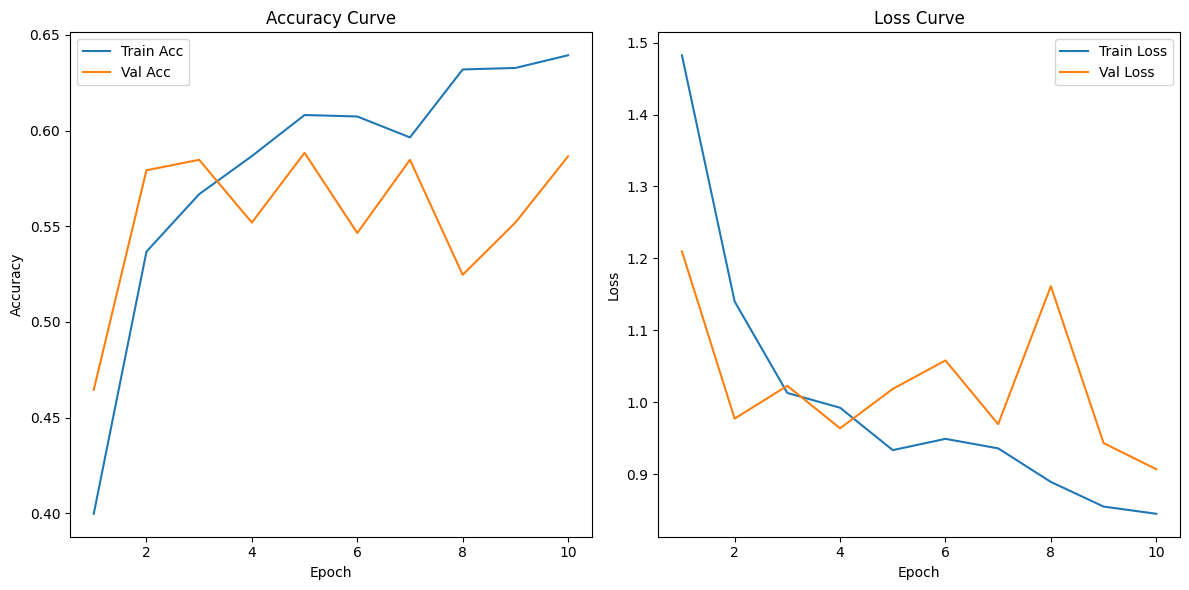

In [ ]:
# ============================================================
# 7. PLOT EPOCH-vs-LOSS AND ACCURACY-vs-LOSS
# ============================================================
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,6))

# Accuracy Curve
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

# Loss Curve
plt.subplot(1,2,2)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# GENERATE TEST SET PREDICTIONS (needed for confusion matrix)
# ============================================================

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

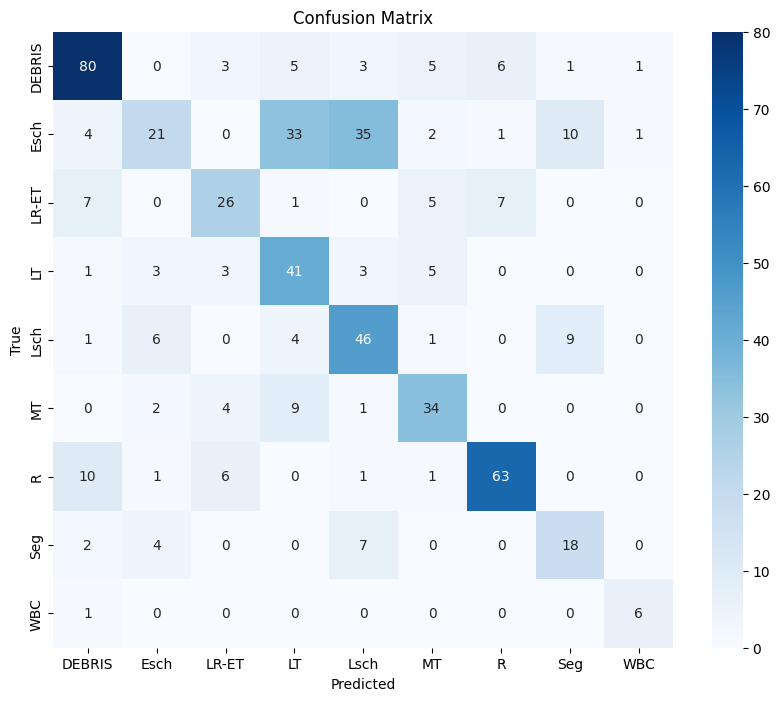

In [ ]:
# ============================================================
# 8. GENERATE CONFUSION MATRIX
# ============================================================

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

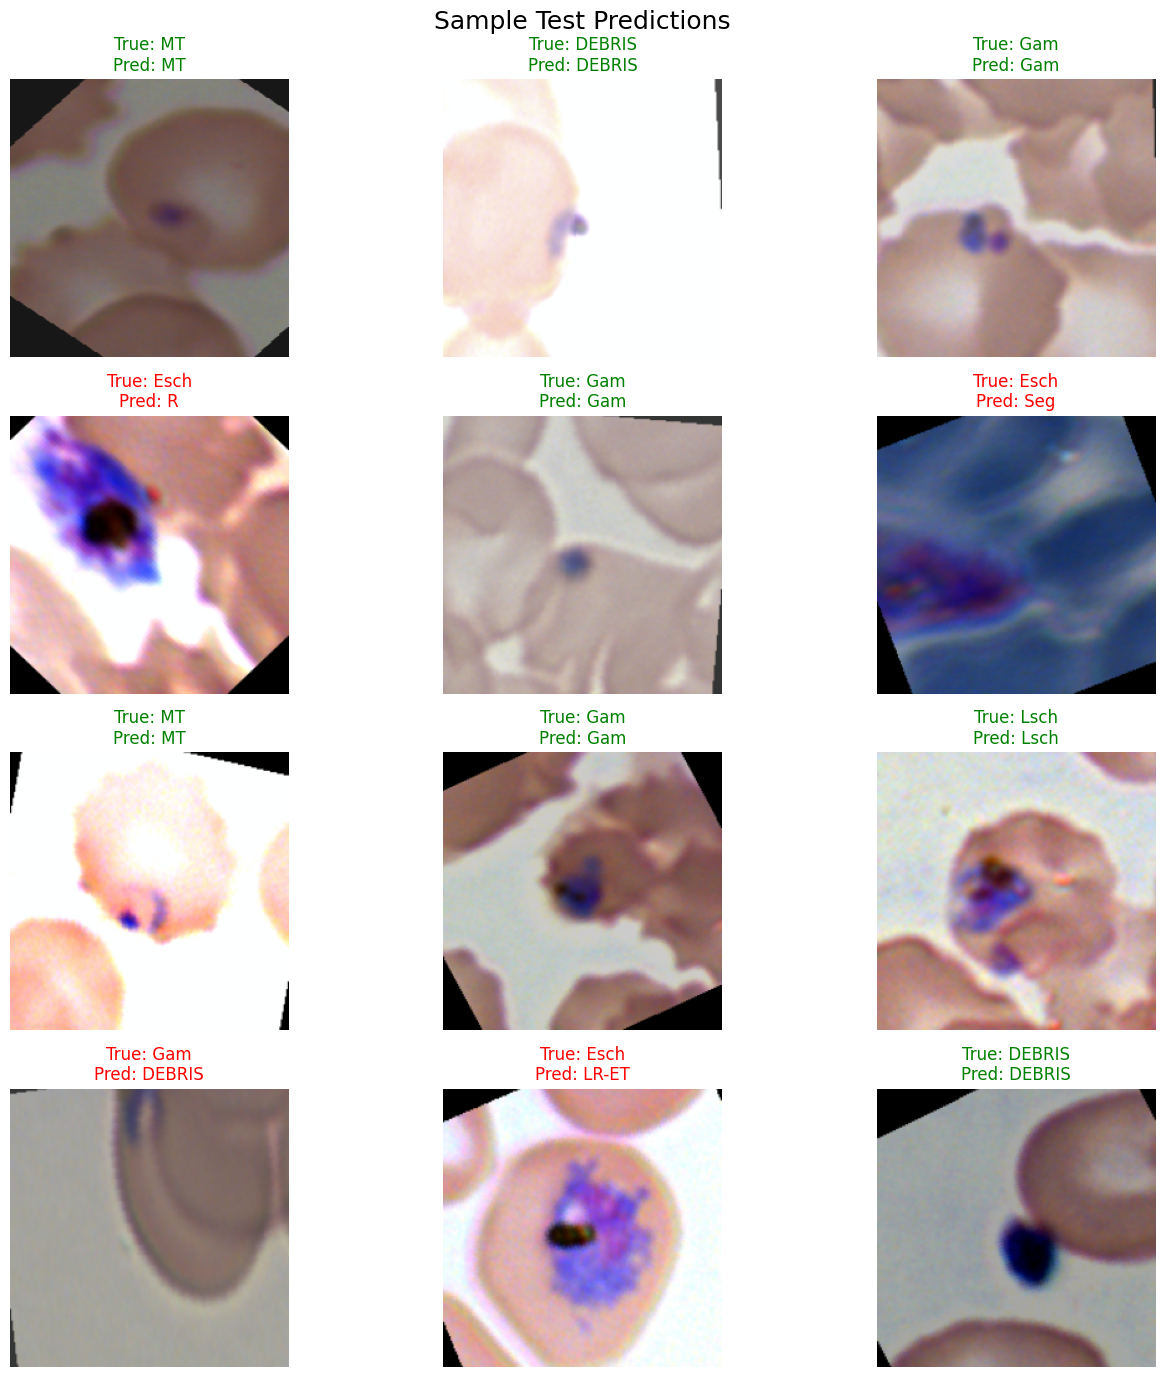

In [ ]:
# ============================================================
# 9. DISPLAY SAMPLE TEST PREDICTIONS
# ============================================================

import random

# choose random 12 images
sample_indices = random.sample(range(len(test_ds)), 12)

plt.figure(figsize=(14,14))

for i, idx in enumerate(sample_indices):
    img, label = test_ds[idx]
    true_class = idx_to_class[label]

    # model expects batch dimension
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_class = idx_to_class[pred.argmax(dim=1).item()]

    # Convert back to displayable image
    # Undo normalization
    img_disp = img.permute(1,2,0).cpu().numpy()
    img_disp = np.clip((img_disp * np.array([0.229,0.224,0.225]) +
                        np.array([0.485,0.456,0.406])), 0, 1)

    plt.subplot(4, 3, i+1)
    plt.imshow(img_disp)
    plt.axis("off")

    title_color = "green" if pred_class == true_class else "red"
    plt.title(f"True: {true_class}\nPred: {pred_class}", color=title_color)

plt.suptitle("Sample Test Predictions", fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
#10. FINAL TEST ACCURACY
# ============================================================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)

        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", test_accuracy)

print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=classes))

Test Accuracy: 0.5890909090909091

Classification report:
              precision    recall  f1-score   support

      DEBRIS       0.77      0.77      0.77       104
        Esch       0.64      0.27      0.38       107
       LR-ET       0.59      0.52      0.55        46
          LT       0.41      0.70      0.52        56
        Lsch       0.42      0.55      0.48        67
          MT       0.56      0.58      0.57        50
           R       0.81      0.76      0.78        82
         Seg       0.43      0.58      0.49        31
         WBC       0.86      0.86      0.86         7

    accuracy                           0.59       550
   macro avg       0.61      0.62      0.60       550
weighted avg       0.62      0.59      0.58       550

